# CRYPTOCURRENCY PRICE PREDICTION

Here's some more details on the project.

Binance has a free public data set called "Klines" available here:
https://github.com/binance/binance-public-data

This data set is a CSV time series that contains price and volume information like "open", "high", "low", "close", "buy volume", "sell volume"

The goal is to see if it's possible to predict any upward or downward movement 5-10 minutes in the future.

I'd like to use an ensemble model (bagging/boosting etc) or similar. I'm not interested in any AI/deep learning at this time.

Potential features include:

- Current price vs 1, 2, 5, 10, 15, 30, 60, 120, 180, 240 etc minutes ago

- (buy volume) - (sell volume) over time

End result should be a jupyter notebook that can show some predictive verification and code to produce the model

## PACKAGE IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from datetime import datetime
%matplotlib inline

## Loading Data of Febuary 2022

In [2]:
cols = ['Open time', 'Open', 'High','Low', 'Close','Volume','Close time','Quote asset volume', 'Number of trades','Taker buy base asset volume','Taker buy quote asset volume','Ignore']

In [41]:
feb_data = pd.read_csv('BTCUSDT-1m-2022-02.csv', names=cols)
feb_data.shape

(40320, 12)

## Exploratory Data Analysis

In [4]:
feb_data.head()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,1643673600000,38466.90,38467.76,38404.03,38404.72,41.91738,1643673659999,1.611058e+06,770,16.08726,618190.583327,0
1,1643673660000,38404.73,38407.90,38324.90,38324.90,53.19024,1643673719999,2.041260e+06,963,18.40635,706420.243960,0
2,1643673720000,38324.91,38371.98,38310.61,38366.40,38.84656,1643673779999,1.489414e+06,954,21.95123,841641.015483,0
3,1643673780000,38366.40,38449.70,38361.17,38418.71,21.21105,1643673839999,8.148023e+05,734,9.64716,370575.353647,0
4,1643673840000,38419.08,38436.93,38406.22,38432.84,6.48054,1643673899999,2.490036e+05,425,3.35164,128785.317972,0


In [5]:
feb_data.tail()

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
40315,1646092500000,43193.52,43213.23,43186.93,43193.57,35.77888,1646092559999,1.545685e+06,975,10.20424,4.408029e+05,0
40316,1646092560000,43193.56,43193.57,43114.75,43149.02,52.81375,1646092619999,2.278620e+06,1520,15.95052,6.880709e+05,0
40317,1646092620000,43149.02,43162.86,43129.88,43162.85,37.29367,1646092679999,1.609076e+06,1160,12.26873,5.293732e+05,0
40318,1646092680000,43162.86,43209.48,43151.41,43205.75,41.56370,1646092739999,1.795044e+06,1329,23.99486,1.036377e+06,0
40319,1646092740000,43205.74,43205.75,43156.66,43160.00,43.19010,1646092799999,1.865145e+06,1128,12.59514,5.438652e+05,0


## Datatypes and Null Values

In [7]:
feb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40320 entries, 0 to 40319
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open time                     40320 non-null  int64  
 1   Open                          40320 non-null  float64
 2   High                          40320 non-null  float64
 3   Low                           40320 non-null  float64
 4   Close                         40320 non-null  float64
 5   Volume                        40320 non-null  float64
 6   Close time                    40320 non-null  int64  
 7   Quote asset volume            40320 non-null  float64
 8   Number of trades              40320 non-null  int64  
 9   Taker buy base asset volume   40320 non-null  float64
 10  Taker buy quote asset volume  40320 non-null  float64
 11  Ignore                        40320 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 3.7 MB


## Data Statistics

In [8]:
feb_data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Open time,40320.0,1.644883e+12,6.983715e+08,1.643674e+12,1.644278e+12,1.644883e+12,1.645488e+12,1.646093e+12
Open,40320.0,4.058250e+04,2.539253e+03,3.435699e+04,3.842182e+04,4.045656e+04,4.274094e+04,4.575462e+04
High,40320.0,4.060615e+04,2.537883e+03,3.442283e+04,3.844434e+04,4.048778e+04,4.276263e+04,4.582100e+04
Low,40320.0,4.055969e+04,2.540388e+03,3.432228e+04,3.840000e+04,4.043446e+04,4.271803e+04,4.560000e+04
Close,40320.0,4.058261e+04,2.539258e+03,3.435698e+04,3.842172e+04,4.045808e+04,4.274156e+04,4.575462e+04
Volume,40320.0,3.108905e+01,4.817933e+01,8.277800e-01,9.526510e+00,1.739469e+01,3.372287e+01,1.205049e+03
Close time,40320.0,1.644883e+12,6.983715e+08,1.643674e+12,1.644278e+12,1.644883e+12,1.645488e+12,1.646093e+12
Quote asset volume,40320.0,1.251485e+06,1.929893e+06,3.494032e+04,3.862115e+05,7.057794e+05,1.358465e+06,4.730718e+07
Number of trades,40320.0,7.968825e+02,9.605526e+02,1.240000e+02,4.040000e+02,5.620000e+02,8.520000e+02,3.980200e+04
Taker buy base asset volume,40320.0,1.542923e+01,2.646512e+01,1.599400e-01,4.128000e+00,8.094615e+00,1.642926e+01,8.332652e+02


## Datetime conversion

In [42]:
feb_data['Open time'] = pd.to_datetime(feb_data['Open time'])
feb_data.sort_values(by=['Open time'], inplace=True, ascending=True)

## CRYPTCURRENCY WITH TIME
LINE PLOTS

## Close

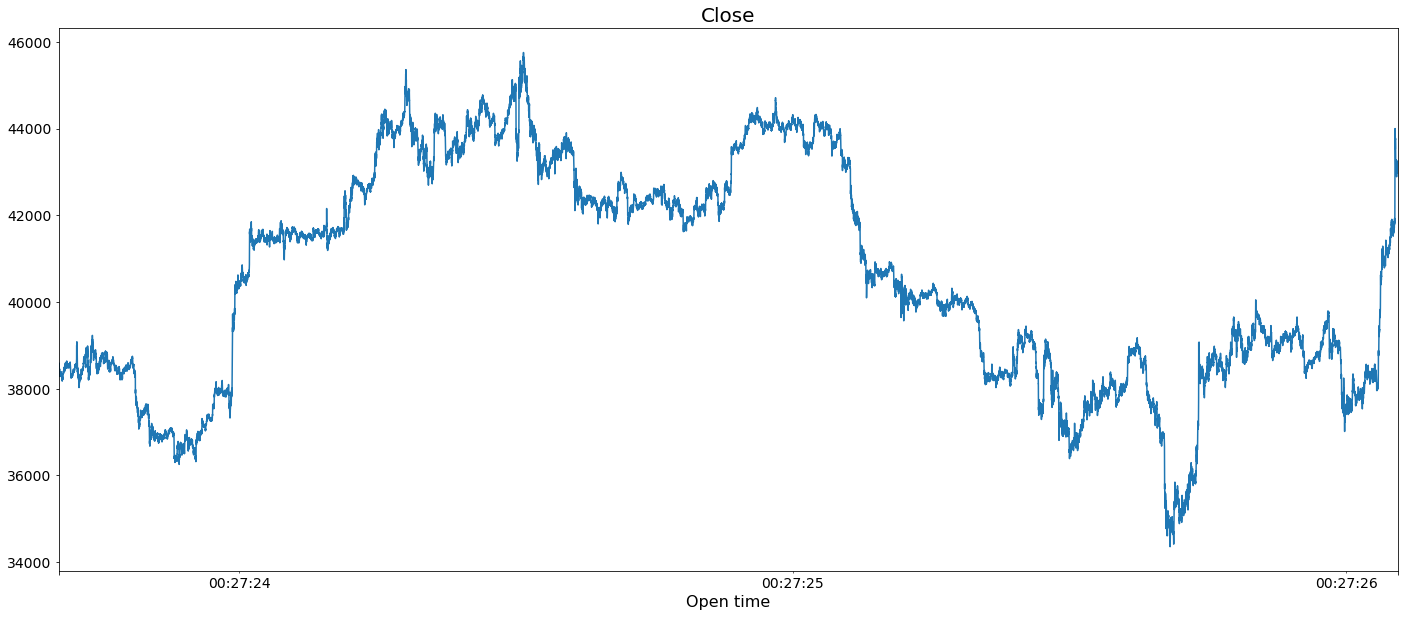

In [43]:
data_copy = feb_data.copy()
data_copy = data_copy.set_index('Open time')
plt.rcParams["figure.figsize"] = (24,10)
ax = data_copy['Close'].plot(fontsize = 14)
plt.title("Close",fontdict={'fontsize':20})
plt.xlabel("Open time", fontdict={'fontsize':16})
plt.show()

## Open

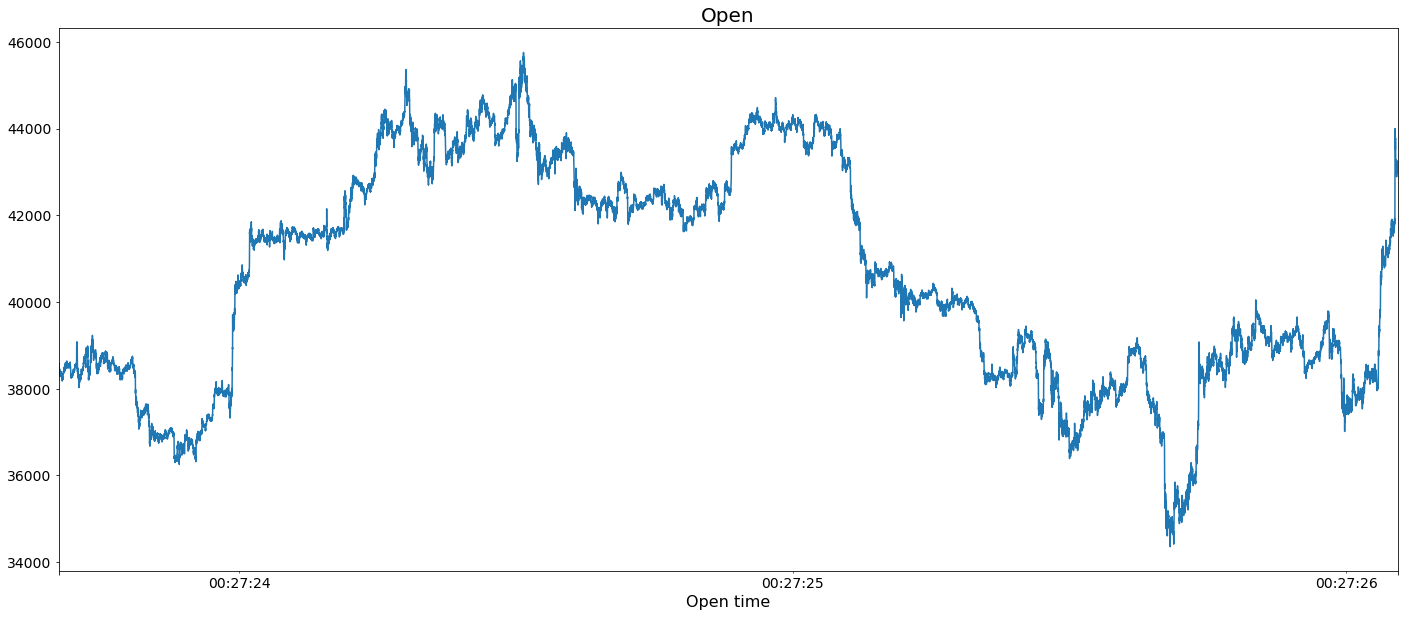

In [44]:
plt.rcParams["figure.figsize"] = (24,10)
ax = data_copy['Open'].plot(fontsize = 14)
plt.title("Open",fontdict={'fontsize':20})
plt.xlabel("Open time", fontdict={'fontsize':16})
plt.show()

## Volume

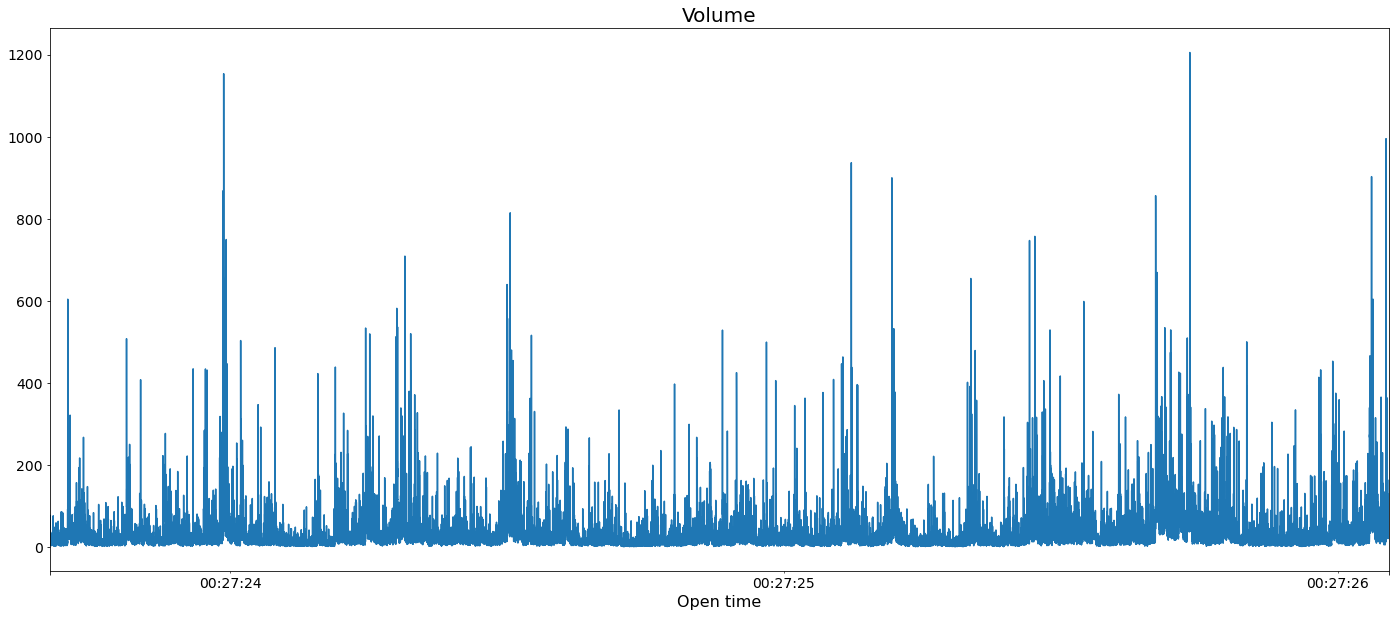

In [45]:
plt.rcParams["figure.figsize"] = (24,10)
ax = data_copy['Volume'].plot(fontsize = 14)
plt.title("Volume",fontdict={'fontsize':20})
plt.xlabel("Open time", fontdict={'fontsize':16})
plt.show()

## Density plot for Open price

<AxesSubplot:xlabel='Open', ylabel='Density'>

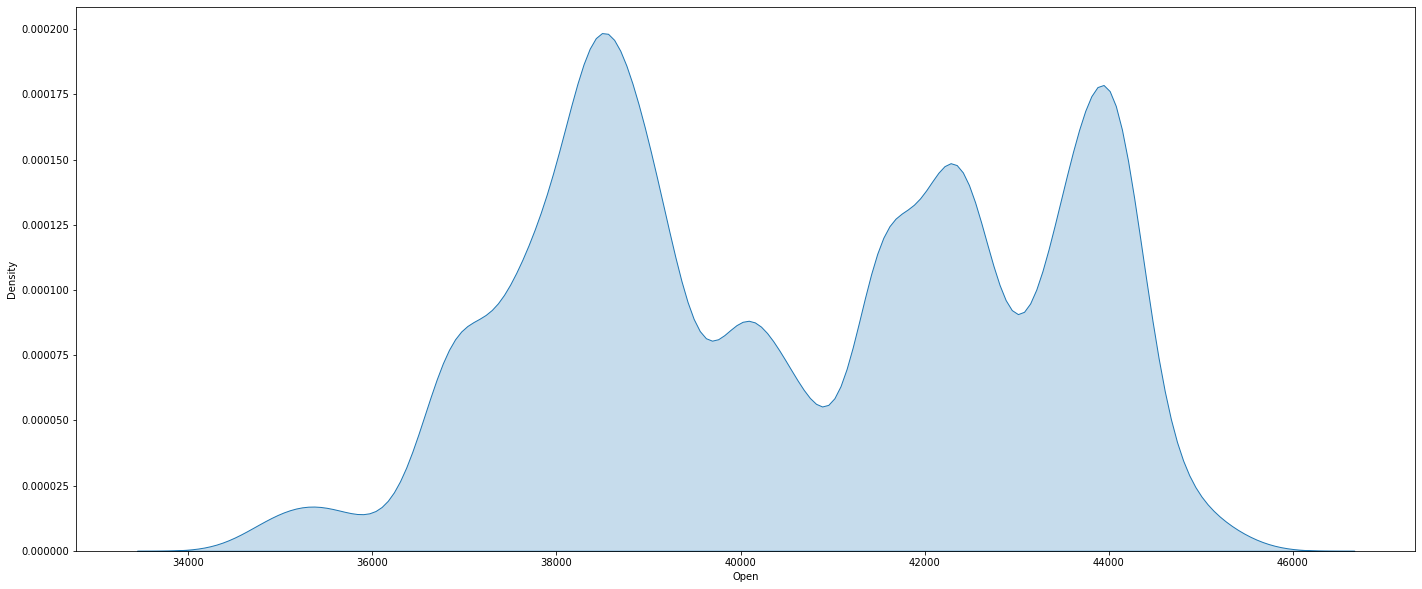

In [47]:
sns.kdeplot(feb_data['Open'], shade=True)

## Minute, Hourly, Daily, and WeeklyLag Plots

No handles with labels found to put in legend.


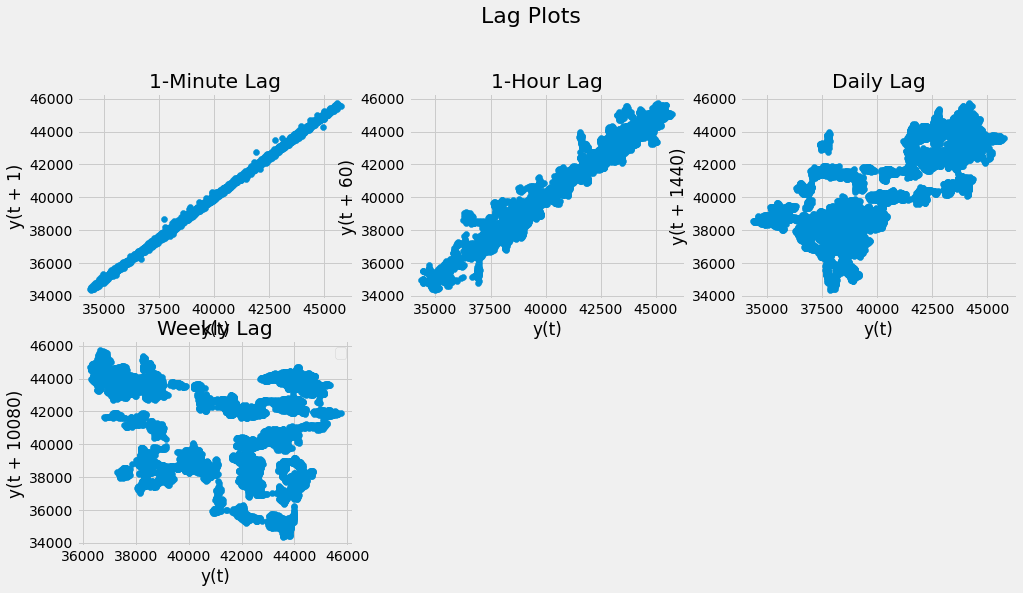

In [152]:
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(feb_data['Open'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(feb_data['Open'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(feb_data['Open'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(feb_data['Open'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.legend()
plt.show()

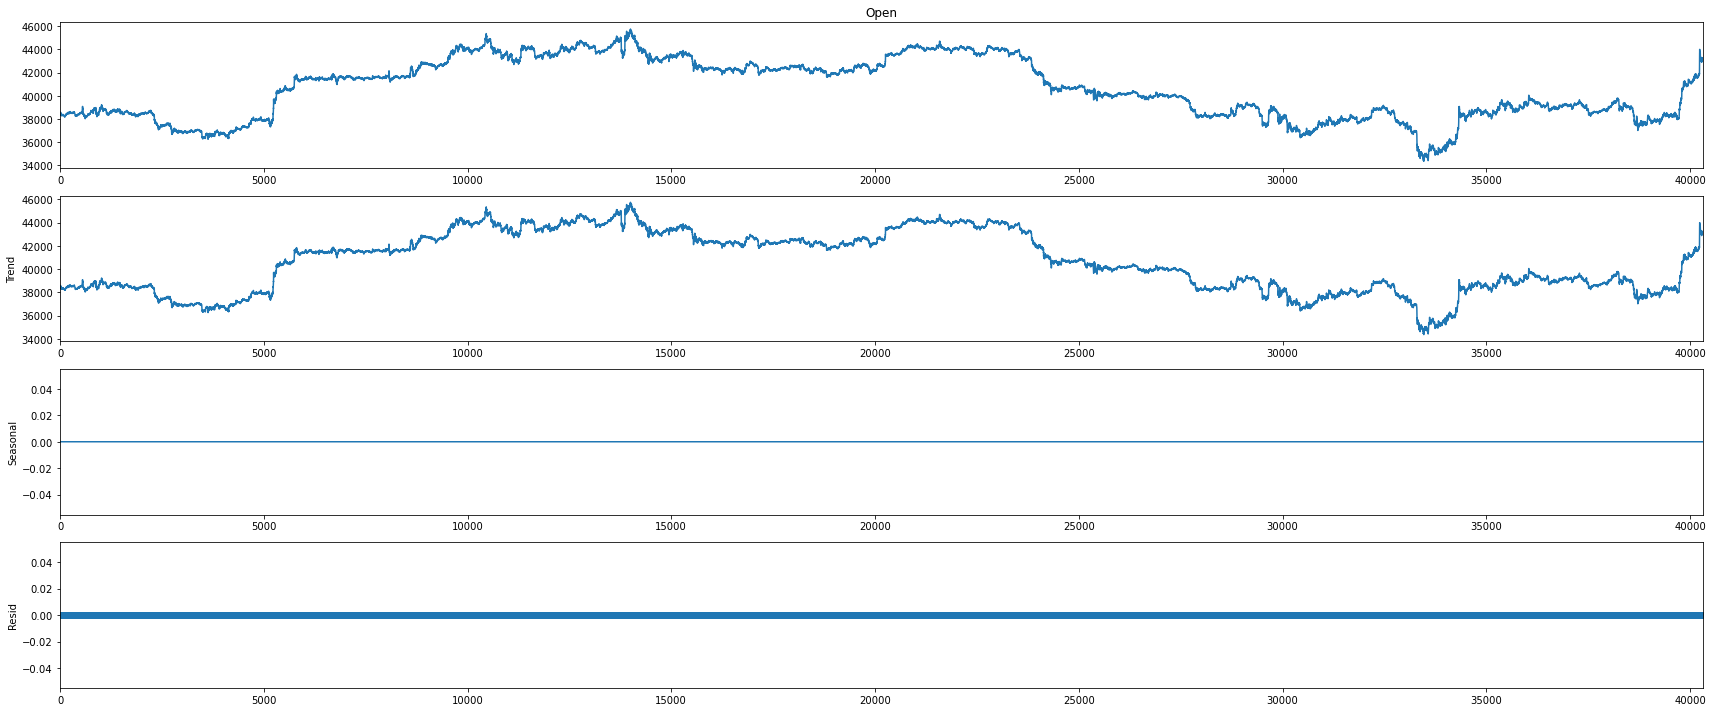

<Figure size 1080x864 with 0 Axes>

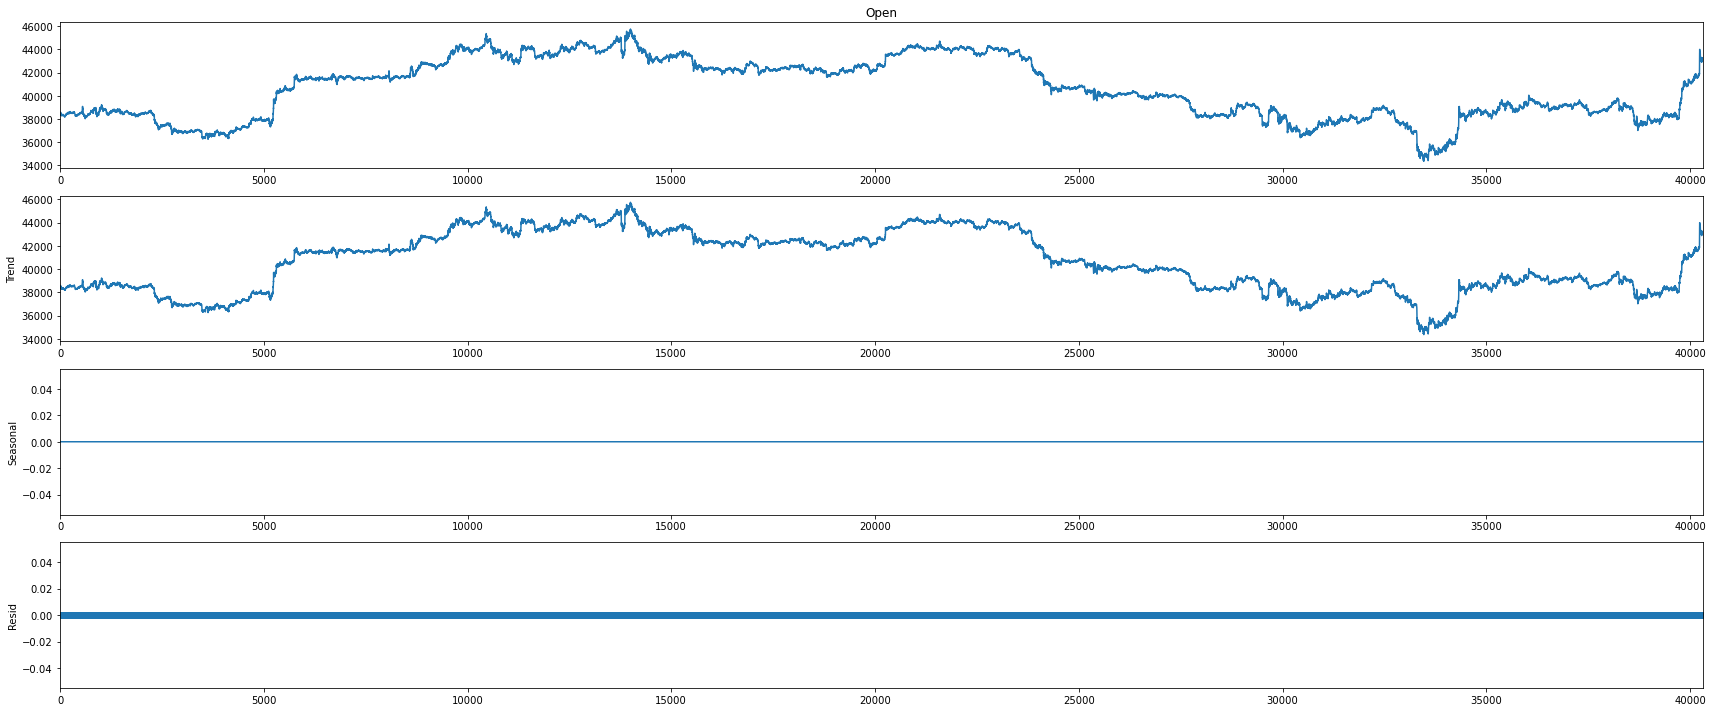

In [49]:
plt.figure(figsize=(15,12))
series = feb_data['Open']
result = seasonal_decompose(series, model='additive',period=1)
result.plot()

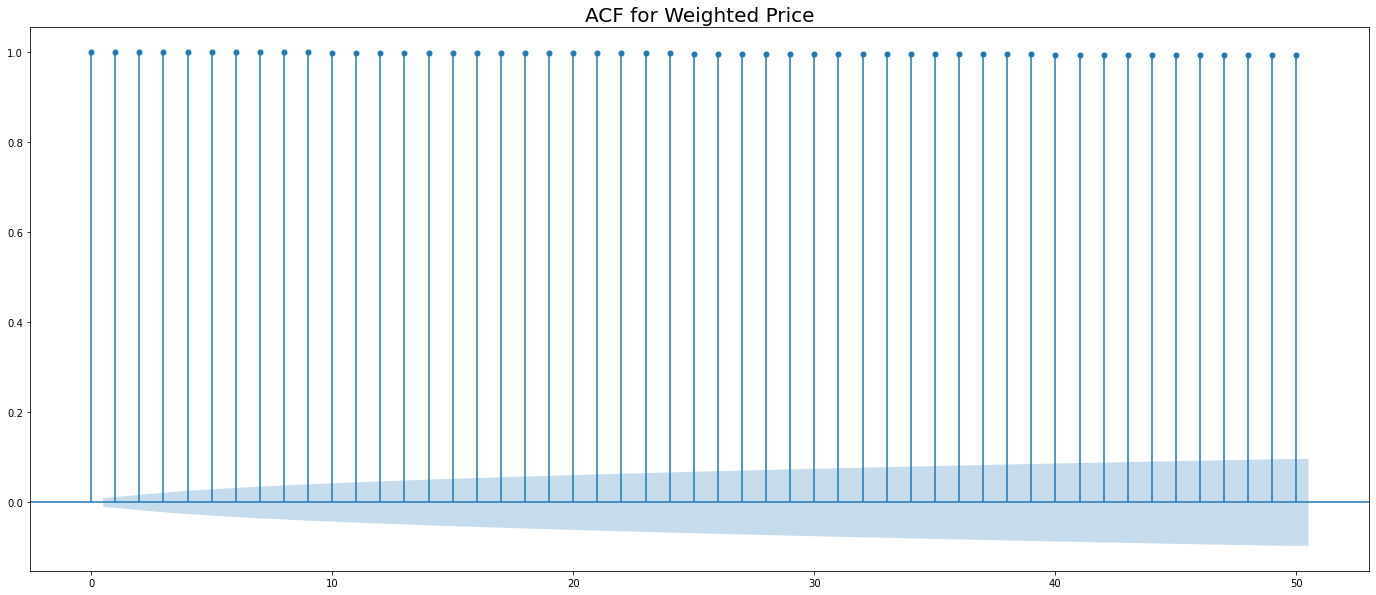

In [50]:
acf = plot_acf(series, lags=50, alpha=0.05)
plt.title("ACF for Weighted Price", size=20)
plt.show()

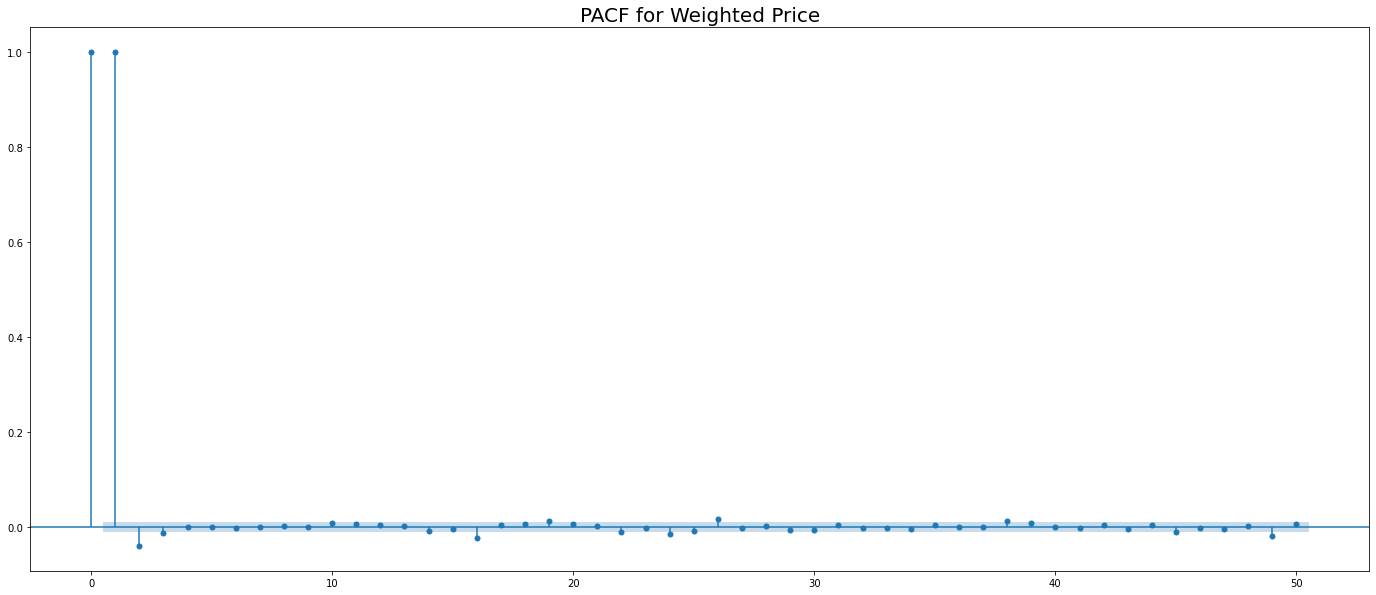

In [51]:
plot_pacf(series, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Weighted Price", size=20)
plt.show()

## Creating Lag features for High, Low, close and Volume

1, 2, 5, 10, 15, 30, 60, 120, 180, 240 etc minutes ago

In [116]:
df = feb_data.set_index("Open time")
df.reset_index(drop=False, inplace=True)

In [117]:
lag_features = ["High", "Low", "Close","Volume"]
window1 = 1
window2 = 2
window5 = 5
window10 = 10
window15 = 15
window30 = 30
window60 = 60
window120 = 120
window180 = 180
window240 = 240

df_rolled_1d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_2d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_5d = df[lag_features].rolling(window=window5, min_periods=0)
df_rolled_10d = df[lag_features].rolling(window=window10, min_periods=0)
df_rolled_15d = df[lag_features].rolling(window=window15, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window30, min_periods=0)
df_rolled_60d = df[lag_features].rolling(window=window60, min_periods=0)
df_rolled_120d = df[lag_features].rolling(window=window120, min_periods=0)
df_rolled_180d = df[lag_features].rolling(window=window180, min_periods=0)
df_rolled_240d = df[lag_features].rolling(window=window240, min_periods=0)

df_mean_1d = df_rolled_1d.mean().shift(1).reset_index()
df_mean_2d = df_rolled_2d.mean().shift(1).reset_index()
df_mean_5d = df_rolled_5d.mean().shift(1).reset_index()
df_mean_10d = df_rolled_10d.mean().shift(1).reset_index()
df_mean_15d = df_rolled_15d.mean().shift(1).reset_index()
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()
df_mean_60d = df_rolled_60d.mean().shift(1).reset_index()
df_mean_120d = df_rolled_120d.mean().shift(1).reset_index()
df_mean_180d = df_rolled_180d.mean().shift(1).reset_index()
df_mean_240d = df_rolled_240d.mean().shift(1).reset_index()

df_std_1d = df_rolled_1d.std().shift(1).reset_index()
df_std_2d = df_rolled_2d.std().shift(1).reset_index()
df_std_5d = df_rolled_5d.std().shift(1).reset_index()
df_std_10d = df_rolled_10d.std().shift(1).reset_index()
df_std_15d = df_rolled_15d.std().shift(1).reset_index()
df_std_30d = df_rolled_30d.std().shift(1).reset_index()
df_std_60d = df_rolled_60d.std().shift(1).reset_index()
df_std_120d = df_rolled_120d.std().shift(1).reset_index()
df_std_180d = df_rolled_180d.std().shift(1).reset_index()
df_std_240d = df_rolled_240d.std().shift(1).reset_index()

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_1d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_2d[feature]
    df[f"{feature}_mean_lag{window5}"] = df_mean_5d[feature]
    df[f"{feature}_mean_lag{window10}"] = df_mean_10d[feature]
    df[f"{feature}_mean_lag{window15}"] = df_mean_15d[feature]
    df[f"{feature}_mean_lag{window30}"] = df_mean_30d[feature]
    df[f"{feature}_mean_lag{window60}"] = df_mean_60d[feature]
    df[f"{feature}_mean_lag{window120}"] = df_mean_120d[feature]
    df[f"{feature}_mean_lag{window180}"] = df_mean_180d[feature]
    df[f"{feature}_mean_lag{window240}"] = df_mean_240d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_1d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_2d[feature]
    df[f"{feature}_std_lag{window5}"] = df_std_5d[feature]
    df[f"{feature}_std_lag{window10}"] = df_std_10d[feature]
    df[f"{feature}_std_lag{window15}"] = df_std_15d[feature]
    df[f"{feature}_std_lag{window30}"] = df_std_30d[feature]
    df[f"{feature}_std_lag{window60}"] = df_std_60d[feature]
    df[f"{feature}_std_lag{window120}"] = df_std_120d[feature]
    df[f"{feature}_std_lag{window180}"] = df_std_180d[feature]
    df[f"{feature}_std_lag{window240}"] = df_std_240d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Open time", drop=False, inplace=True)
df.head()

C:\Users\musht\AppData\Local\Temp/ipykernel_17788/489720424.py:69: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)


,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,Volume_std_lag1,Volume_std_lag2,Volume_std_lag5,Volume_std_lag10,Volume_std_lag15,Volume_std_lag30,Volume_std_lag60,Volume_std_lag120,Volume_std_lag180,Volume_std_lag240
Open time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:27:23.673600,1970-01-01 00:27:23.673600,38466.90,38467.76,38404.03,38404.72,41.91738,1643673659999,1.611058e+06,770,16.08726,...,NaN,13.380803,18.182442,21.353275,23.196911,26.301787,29.359035,32.270601,33.900890,35.042025
1970-01-01 00:27:23.673660,1970-01-01 00:27:23.673660,38404.73,38407.90,38324.90,38324.90,53.19024,1643673719999,2.041260e+06,963,18.40635,...,NaN,13.380803,18.182442,21.353275,23.196911,26.301787,29.359035,32.270601,33.900890,35.042025
1970-01-01 00:27:23.673720,1970-01-01 00:27:23.673720,38324.91,38371.98,38310.61,38366.40,38.84656,1643673779999,1.489414e+06,954,21.95123,...,NaN,7.971116,7.971116,7.971116,7.971116,7.971116,7.971116,7.971116,7.971116,7.971116
1970-01-01 00:27:23.673780,1970-01-01 00:27:23.673780,38366.40,38449.70,38361.17,38418.71,21.21105,1643673839999,8.148023e+05,734,9.64716,...,NaN,10.142513,7.552576,7.552576,7.552576,7.552576,7.552576,7.552576,7.552576,7.552576
1970-01-01 00:27:23.673840,1970-01-01 00:27:23.673840,38419.08,38436.93,38406.22,38432.84,6.48054,1643673899999,2.490036e+05,425,3.35164,...,NaN,12.470189,13.243490,13.243490,13.243490,13.243490,13.243490,13.243490,13.243490,13.243490


## Dropping columns have only null values

In [118]:
del_cols = ['Volume_std_lag1', 'Close_std_lag1', 'Low_std_lag1', 'High_std_lag1']
for col in del_cols:
    del df[col]

## Creating Date features

In [120]:
df["week"] = df['Open time'].dt.week
df["day"] = df['Open time'].dt.day
df["day_of_week"] = df['Open time'].dt.dayofweek
df.head()

C:\Users\musht\AppData\Local\Temp/ipykernel_17788/1221389423.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = df['Open time'].dt.week


,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,...,Volume_std_lag10,Volume_std_lag15,Volume_std_lag30,Volume_std_lag60,Volume_std_lag120,Volume_std_lag180,Volume_std_lag240,week,day,day_of_week
Open time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:27:23.673600,1970-01-01 00:27:23.673600,38466.90,38467.76,38404.03,38404.72,41.91738,1643673659999,1.611058e+06,770,16.08726,...,21.353275,23.196911,26.301787,29.359035,32.270601,33.900890,35.042025,1,1,3
1970-01-01 00:27:23.673660,1970-01-01 00:27:23.673660,38404.73,38407.90,38324.90,38324.90,53.19024,1643673719999,2.041260e+06,963,18.40635,...,21.353275,23.196911,26.301787,29.359035,32.270601,33.900890,35.042025,1,1,3
1970-01-01 00:27:23.673720,1970-01-01 00:27:23.673720,38324.91,38371.98,38310.61,38366.40,38.84656,1643673779999,1.489414e+06,954,21.95123,...,7.971116,7.971116,7.971116,7.971116,7.971116,7.971116,7.971116,1,1,3
1970-01-01 00:27:23.673780,1970-01-01 00:27:23.673780,38366.40,38449.70,38361.17,38418.71,21.21105,1643673839999,8.148023e+05,734,9.64716,...,7.552576,7.552576,7.552576,7.552576,7.552576,7.552576,7.552576,1,1,3
1970-01-01 00:27:23.673840,1970-01-01 00:27:23.673840,38419.08,38436.93,38406.22,38432.84,6.48054,1643673899999,2.490036e+05,425,3.35164,...,13.243490,13.243490,13.243490,13.243490,13.243490,13.243490,13.243490,1,1,3


## Train Test Split
First 80% as train and last 20% as test

In [121]:
#df = df.fillna(df.median())
#df.dropna(inplace=True)
df_train = df.iloc[:32256,:]
df_valid = df.iloc[32256:,:]

print('train shape :', df_train.shape)
print('validation shape :', df_valid.shape)

train shape : (32256, 91)
validation shape : (8064, 91)


In [123]:
exogenous_features = ['High_mean_lag1',
       'High_mean_lag2', 'High_mean_lag5', 'High_mean_lag10',
       'High_mean_lag15', 'High_mean_lag30', 'High_mean_lag60',
       'High_mean_lag120', 'High_mean_lag180', 'High_mean_lag240', 'High_std_lag2', 'High_std_lag5', 'High_std_lag10',
       'High_std_lag15', 'High_std_lag30', 'High_std_lag60', 'High_std_lag120',
       'High_std_lag180', 'High_std_lag240', 'Low_mean_lag1', 'Low_mean_lag2',
       'Low_mean_lag5', 'Low_mean_lag10', 'Low_mean_lag15', 'Low_mean_lag30',
       'Low_mean_lag60', 'Low_mean_lag120', 'Low_mean_lag180',
       'Low_mean_lag240', 'Low_std_lag2', 'Low_std_lag5',
       'Low_std_lag10', 'Low_std_lag15', 'Low_std_lag30', 'Low_std_lag60',
       'Low_std_lag120', 'Low_std_lag180', 'Low_std_lag240', 'Close_mean_lag1',
       'Close_mean_lag2', 'Close_mean_lag5', 'Close_mean_lag10',
       'Close_mean_lag15', 'Close_mean_lag30', 'Close_mean_lag60',
       'Close_mean_lag120', 'Close_mean_lag180', 'Close_mean_lag240', 'Close_std_lag2', 'Close_std_lag5', 'Close_std_lag10',
       'Close_std_lag15', 'Close_std_lag30', 'Close_std_lag60',
       'Close_std_lag120', 'Close_std_lag180', 'Close_std_lag240',
       'Volume_mean_lag1', 'Volume_mean_lag2', 'Volume_mean_lag5',
       'Volume_mean_lag10', 'Volume_mean_lag15', 'Volume_mean_lag30',
       'Volume_mean_lag60', 'Volume_mean_lag120', 'Volume_mean_lag180',
       'Volume_mean_lag240', 'Volume_std_lag2',
       'Volume_std_lag5', 'Volume_std_lag10', 'Volume_std_lag15',
       'Volume_std_lag30', 'Volume_std_lag60', 'Volume_std_lag120',
       'Volume_std_lag180', 'Volume_std_lag240', 'week', 'day', 'day_of_week']

## Training ARIMA model

In [124]:
model = pm.auto_arima(df_train.Open, exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(df_train.Open, exogenous=df_train[exogenous_features])

forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
df_valid["Forecast_ARIMAX"] = forecast

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=553536.002, Time=47.61 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=nan sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 48.008 seconds


C:\Users\musht\AppData\Local\Temp/ipykernel_17788/184789529.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["Forecast_ARIMAX"] = forecast


## Prediction on test set

<AxesSubplot:xlabel='Open time'>

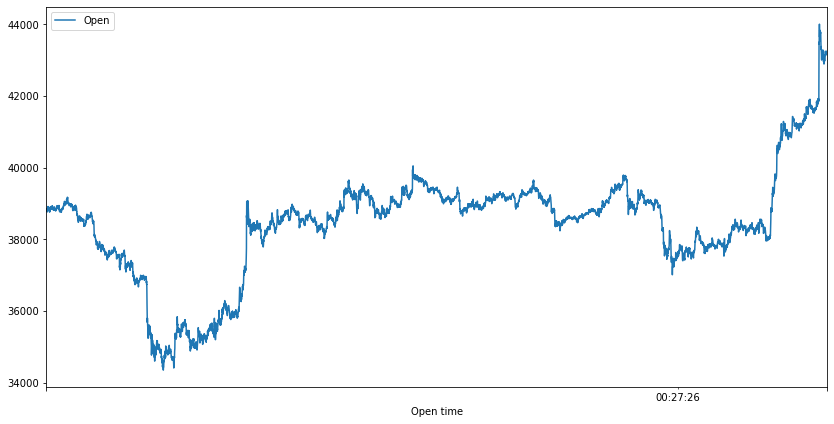

In [127]:
df_valid[["Open"]].plot(figsize=(14, 7))

<AxesSubplot:xlabel='Open time'>

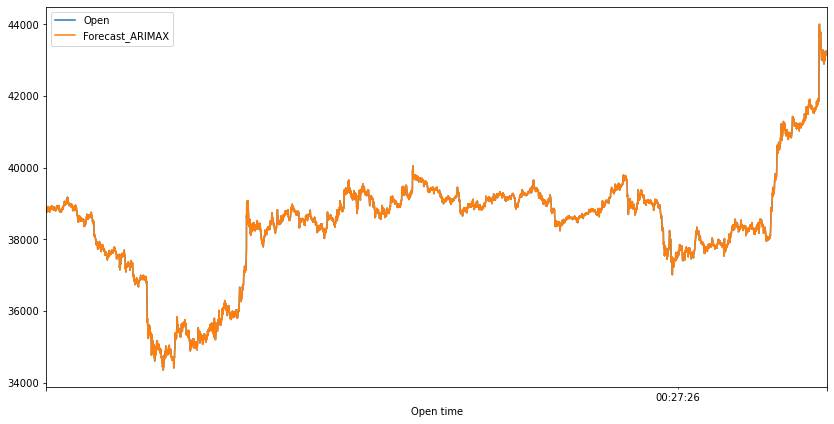

In [126]:
df_valid[["Open", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

## Print the Errors

In [128]:
print("RMSE of Auto ARIMAX:", np.sqrt(mean_squared_error(df_valid.Open, df_valid.Forecast_ARIMAX)))

print("\nMAE of Auto ARIMAX:", mean_absolute_error(df_valid.Open, df_valid.Forecast_ARIMAX))

RMSE of Auto ARIMAX: 0.5887320416266076

MAE of Auto ARIMAX: 0.21027702524528225


# --------------------------------------------------------------------------------------------

## Training Ensemble Model
## XgBoost

In [132]:
X_train, y_train = df_train[exogenous_features], df_train.Open
X_test, y_test = df_valid[exogenous_features], df_valid.Open

In [133]:
reg = xgb.XGBRegressor()

## Hyperparameter Tuning

In [134]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
 
}

In [135]:
model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [136]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                  

In [137]:
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

Model Best Score : 0.999439148074097
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bynode': 1, 'colsample_bytree': 0.8, 'enable_categorical': False, 'gamma': 0.8, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 11, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1366, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'exact', 'validate_parameters': 1, 'verbosity': None}


## Best parameters

In [138]:
model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.6,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0.8, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=11, missing=nan,
             monotone_constraints='()', n_estimators=1366, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Prediction on trained data

C:\Users\musht\AppData\Local\Temp/ipykernel_17788/2966849003.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Predicted_Open_Price'] = model.predict(X_train)


<AxesSubplot:xlabel='Open time'>

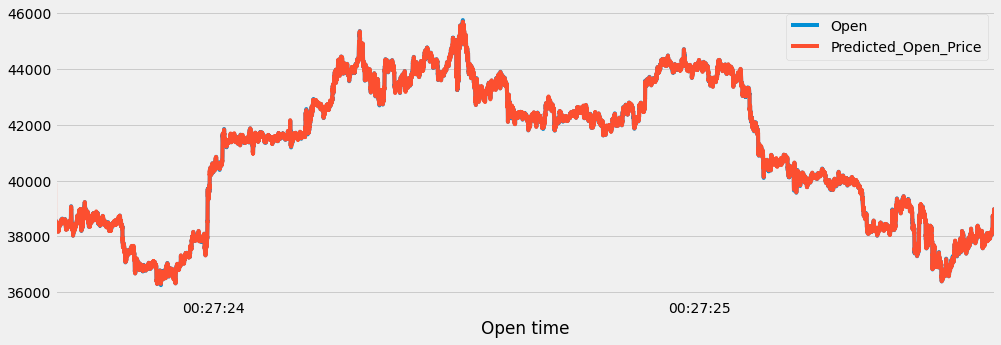

In [139]:
df_train['Predicted_Open_Price'] = model.predict(X_train)

df_train[['Open','Predicted_Open_Price']].plot(figsize=(15, 5))

In [140]:
df_valid['Forecast_XGBoost'] = model.predict(X_test)

overall_data = pd.concat([df_train, df_valid], sort=False)

C:\Users\musht\AppData\Local\Temp/ipykernel_17788/390820625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid['Forecast_XGBoost'] = model.predict(X_test)


## Prediction on test data

<AxesSubplot:xlabel='Open time'>

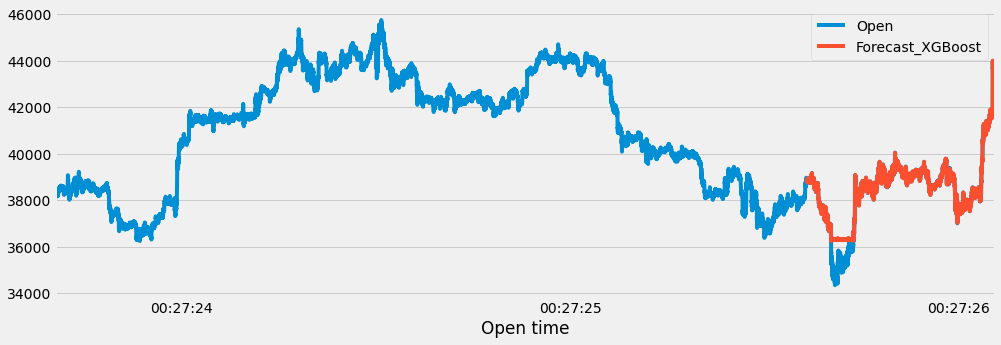

In [142]:
overall_data[['Open','Forecast_XGBoost']].plot(figsize=(15, 5))

<AxesSubplot:xlabel='Open time'>

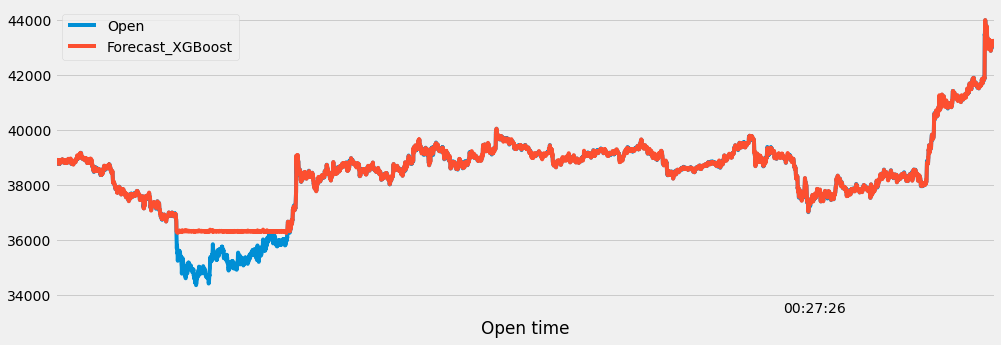

In [143]:
df_valid[['Open','Forecast_XGBoost']].plot(figsize=(15, 5))

## Print the different traing and testing Errors

In [147]:
train_mae = mean_absolute_error(df_train['Open'], df_train['Predicted_Open_Price'])
train_rmse = np.sqrt(mean_squared_error(df_train['Open'], df_train['Predicted_Open_Price']))
train_r2 = r2_score(df_train['Open'], df_train['Predicted_Open_Price'])

print(f"train MAE : {train_mae}")
print(f"train RMSE : {train_rmse}")
print(f"train R2 : {train_r2}")

train MAE : 8.71882753886872
train RMSE : 14.207561985508324
train R2 : 0.9999666763148964


In [148]:
test_mae = mean_absolute_error(df_valid['Open'], df_valid['Forecast_XGBoost'])
test_rmse = np.sqrt(mean_squared_error(df_valid['Open'], df_valid['Forecast_XGBoost']))
test_r2 = r2_score(df_valid['Open'], df_valid['Forecast_XGBoost'])

print(f"test MAE : {test_mae}")
print(f"test RMSE : {test_rmse}")
print(f"test R2 : {test_r2}")

test MAE : 124.789481937469
test RMSE : 359.1922691381087
test R2 : 0.9413620269491918


## ARIMA and Ensemble Model Comparision on test set

<AxesSubplot:xlabel='Open time'>

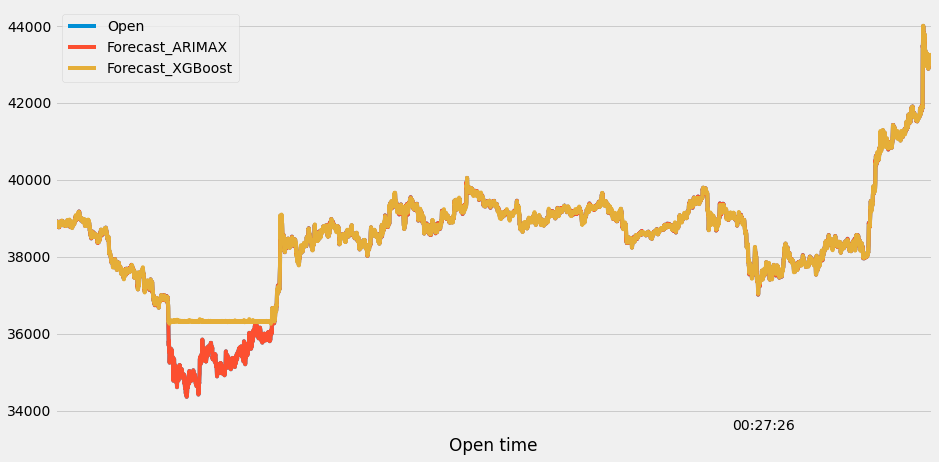

In [149]:
df_valid[["Open", "Forecast_ARIMAX", "Forecast_XGBoost"]].plot(figsize=(14,7))